In [1]:
import joblib
import xarray as xr
import pandas as pd
import anndata
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix, vstack
import matplotlib.pyplot as plt

## Load Data

### Cell type phylogeny

In [2]:
node_cluster_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.non_singleton_node_dict.lib'
)

cluster_dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib'
)
cluster_linkage = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.csv', index_col=0).values
cluster_linkage_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.orders.txt', 
    index_col=0, header=None
).index

cluster_linkage_order = [i.replace(' ', '_') for i in cluster_linkage_order]
name_map = {i.replace('_', '.').replace('-', '.'):i for i in cluster_linkage_order}
cluster_dendro['ivl'] = [name_map[i] for i in cluster_dendro['ivl']]

### Gene

#### DMG

In [3]:
related_dmg = pd.read_msgpack('RelatedDMG.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Gene meta

In [4]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

#### Subtype gene rate

In [5]:
subtype_rate = xr.open_dataset(
    '/home/hanliu/project/mouse_rostral_brain/study/mCClustermCLevel/SubType.geneslop2k.mcds'
)['gene_cluster_da_rate'].sel(mc_type='CHN').to_pandas().T
subtype_rate.columns = subtype_rate.columns.str.replace(' ', '_')
subtype_rate.head()

SubType,MGE-Sst_Rxra,CA3_Cadm2,CA1_Chrm3,CA3-St18_Tead1,Unc5c_Unc5c,Gfra1_Gfra1,ODC_odc-small,PC_pc-all,ODC_odc-large,ANP_anp-dg,...,D1L-PAL_Plcxd3,PAL-Inh_Onecut2,LSX-Inh_Foxp2,LSX-Inh_Enox1,MSN-D1_Outlier,LSX-Inh_Dock10,LSX-Inh_Nxph1,LSX-Inh_Zeb2,LSX-Inh_Lats2,PT-L5_Outlier
geneslop2k,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.036028,0.033156,0.023127,0.027134,0.024149,0.030705,0.007401,0.004408,0.006504,0.005405,...,0.011507,0.042900,0.028670,0.025057,0.026316,0.022981,0.022370,0.019700,0.018092,0.018018
ENSMUSG00000064842.1,0.043546,0.029851,0.024722,0.027768,0.030352,0.039891,0.009691,0.004859,0.009342,0.006471,...,0.014913,0.049733,0.032969,0.029144,NaN,0.028612,0.030037,0.026626,0.031396,0.000000
ENSMUSG00000051951.5,0.011518,0.009630,0.008233,0.017092,0.011801,0.014484,0.018628,0.004790,0.015895,0.005185,...,0.012604,0.023654,0.026305,0.021451,0.013525,0.024743,0.022012,0.025300,0.021889,0.022814
ENSMUSG00000102851.1,0.012793,0.008696,0.008266,0.013822,0.010621,0.012788,0.013043,0.005251,0.013161,0.004871,...,0.012873,0.025467,0.030113,0.022554,0.000000,0.024056,0.025327,0.024327,0.015444,NaN
ENSMUSG00000103377.1,0.008664,0.009502,0.009479,0.024804,0.010696,0.016256,0.049207,0.004797,0.038580,0.005653,...,0.014659,0.025282,0.034705,0.026059,0.000000,0.032258,0.030009,0.032695,0.029836,0.015038


### Gene assign to node result

In [6]:
total_result = pd.read_msgpack('NodeGeneResults.msg')

### DMR

#### DMG DMR Corr

In [7]:
# dmr_gene_corr = pd.read_msgpack(
#     '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/TotalGeneDMRCorrLoop.0.3.msg')

#### DMR Rate

In [8]:
dmr_rate = pd.read_hdf(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5',
    key='Rate').loc[:, cluster_dendro['ivl']].copy()

#### DMR Hits

In [9]:
hypo_hits = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/TotalHits.HypoDMR.h5ad'
)[:, cluster_dendro['ivl']].copy()

## Select gene per node

In [10]:
cutoff = 0.1

node_dict = {}
for node, row in total_result.iterrows():
    node_record = total_result.loc[node]
    left_gene = node_record[node_record < -cutoff].abs()
    right_gene = node_record[node_record > cutoff]
    node_dict[node] = {'left': left_gene, 'right': right_gene}
    # print(node, left_gene.size, right_gene.size)

In [11]:
# sns.clustermap(subtype_rate.loc[left_gene.index, cluster_linkage_order].fillna(0.8), 
#                col_linkage=cluster_linkage, vmin=0, vmax=0.03)
# sns.clustermap(subtype_rate.loc[right_gene.index, cluster_linkage_order].fillna(0.8), 
#                col_linkage=cluster_linkage, vmin=0, vmax=0.03)

## Select DMR

- DMR is correlated to gene
- DMR is also relavent to the node

In [12]:
node=130

left_nodes = [i.replace(' ', '_') for i in node_cluster_dict[node]['left']]
right_nodes = [
        i.replace(' ', '_') for i in node_cluster_dict[node]['right']
]
    


In [13]:
def get_node_relavent_dmr(node, abs_cutoff=0.1):
    left_gene = node_dict[node]['left']
    right_gene = node_dict[node]['right']

    left_nodes = [i.replace(' ', '_') for i in node_cluster_dict[node]['left']]
    right_nodes = [
        i.replace(' ', '_') for i in node_cluster_dict[node]['right']
    ]

    n_left = len(left_nodes)
    n_right = len(right_nodes)

    # left_dmr = dmr_gene_corr[dmr_gene_corr['Gene'].isin(
    #     left_gene.index)]['DMR'].drop_duplicates()
    # right_dmr = dmr_gene_corr[dmr_gene_corr['Gene'].isin(
    #     right_gene.index)]['DMR'].drop_duplicates()
    total_node_dmr = hypo_hits[:, left_nodes+right_nodes].X.sum(axis=1).A1 != 0
    print(f'{node} gene', left_gene.size, right_gene.size)
    print(f'{node} total DMR', total_node_dmr.sum())
    
    related_hits = hypo_hits[total_node_dmr, :].copy()
    # return related_hits, left_nodes, right_nodes
    if len(left_nodes) > 1:
        left_hits = related_hits[:, left_nodes].X.sum(axis=1).A1
    else:
        left_hits = related_hits[:, left_nodes].X
    if len(right_nodes) > 1:
        right_hits = related_hits[:, right_nodes].X.sum(axis=1).A1
    else:
        right_hits = related_hits[:, right_nodes].X

    # approximate relavent score, prevent redo test: (N * (M-m) - M * (N-n)) / N * M
    # positive score is left hypo DMR, negative score is right hypo DMR
    dmr_relavent_score = pd.Series(
        (left_hits * (n_right - right_hits) - right_hits *
         (n_left - left_hits)) / (n_left * n_right),
        index=related_hits.obs_names)
    dmr_relavent_score.name = node
    return dmr_relavent_score

In [14]:
data_list = []
node_list = []
for node in node_cluster_dict.keys():
    use_dmr = get_node_relavent_dmr(node, abs_cutoff=0)
    use_dmr = use_dmr[use_dmr.abs() > 0.5]
    sparse_data = csr_matrix(use_dmr.reindex(dmr_rate.index).fillna(0).values[None, :])
    node_list.append(node)
    data_list.append(sparse_data)
    print(f'{node} related dmr', use_dmr.size)

77 gene 0 0
77 total DMR 260027


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


77 related dmr 102493
78 gene 13 3
78 total DMR 203703


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


78 related dmr 108889
79 gene 8 0
79 total DMR 514340


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


79 related dmr 203024
80 gene 1 4
80 total DMR 336713


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


80 related dmr 97664
81 gene 0 2
81 total DMR 319616


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


81 related dmr 116201
82 gene 5 0
82 total DMR 269896


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


82 related dmr 172447
83 gene 2 5
83 total DMR 325323


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


83 related dmr 156720
84 gene 0 0
84 total DMR 261537


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


84 related dmr 157637
85 gene 3 2
85 total DMR 301798


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


85 related dmr 80864
86 gene 1 2
86 total DMR 207777


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


86 related dmr 129782
87 gene 0 3
87 total DMR 234757


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


87 related dmr 115055
88 gene 0 6
88 total DMR 399273


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


88 related dmr 144573
89 gene 18 26
89 total DMR 273412


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


89 related dmr 212221
90 gene 4 7
90 total DMR 385774


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


90 related dmr 77595
91 gene 1 0
91 total DMR 61209


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


91 related dmr 48566
92 gene 5 2
92 total DMR 216878


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


92 related dmr 147259
93 gene 10 11
93 total DMR 285627


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


93 related dmr 104550
94 gene 13 17
94 total DMR 322895


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


94 related dmr 140459
95 gene 3 2
95 total DMR 176699


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


95 related dmr 107045
96 gene 8 34
96 total DMR 345430


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


96 related dmr 97686
97 gene 2 25
97 total DMR 123496


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


97 related dmr 117840
98 gene 5 28
98 total DMR 369934


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


98 related dmr 161559
99 gene 17 3
99 total DMR 577451


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


99 related dmr 131322
100 gene 0 6
100 total DMR 227182


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


100 related dmr 184207
101 gene 0 2
101 total DMR 142891


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


101 related dmr 106724
102 gene 2 2
102 total DMR 162345


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


102 related dmr 125481
103 gene 3 1
103 total DMR 91530


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


103 related dmr 34503
104 gene 5 5
104 total DMR 125966


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


104 related dmr 7592
105 gene 16 35
105 total DMR 414536
105 related dmr 48715
106 gene 17 22
106 total DMR 431546
106 related dmr 37551
107 gene 1 1
107 total DMR 298363


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


107 related dmr 178286
108 gene 9 9
108 total DMR 347962


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


108 related dmr 243737
109 gene 22 32
109 total DMR 394726


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


109 related dmr 159685
110 gene 17 34
110 total DMR 454212


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


110 related dmr 188889
111 gene 6 15
111 total DMR 269945


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


111 related dmr 188352
112 gene 35 6
112 total DMR 300193


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


112 related dmr 166769
113 gene 6 5
113 total DMR 276573


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


113 related dmr 171218
114 gene 38 34
114 total DMR 389976
114 related dmr 28721
115 gene 38 27
115 total DMR 432923
115 related dmr 75783
116 gene 0 2
116 total DMR 216093


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


116 related dmr 140816
117 gene 25 71
117 total DMR 557982
117 related dmr 47947
118 gene 8 29
118 total DMR 321378


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


118 related dmr 205969
119 gene 53 38
119 total DMR 509280
119 related dmr 75914
120 gene 18 20
120 total DMR 198345


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


120 related dmr 98609
121 gene 13 41
121 total DMR 441104
121 related dmr 40415
122 gene 6 48
122 total DMR 276685


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


122 related dmr 73612
123 gene 14 17
123 total DMR 222757


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


123 related dmr 163563
124 gene 311 126
124 total DMR 379215


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


124 related dmr 143487
125 gene 91 44
125 total DMR 430136
125 related dmr 49476
126 gene 42 25
126 total DMR 377436
126 related dmr 9534
127 gene 60 42
127 total DMR 633622


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


127 related dmr 282254
128 gene 11 89
128 total DMR 443381
128 related dmr 69265
129 gene 46 88
129 total DMR 443257


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


129 related dmr 136657
130 gene 57 157
130 total DMR 617718
130 related dmr 122377
131 gene 17 9
131 total DMR 181618


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


131 related dmr 150775
132 gene 87 67
132 total DMR 694336
132 related dmr 55423
133 gene 86 102
133 total DMR 545925


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


133 related dmr 233450
134 gene 318 820
134 total DMR 511679


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


134 related dmr 236635
135 gene 740 431
135 total DMR 614788


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


135 related dmr 165866
136 gene 170 73
136 total DMR 736117
136 related dmr 88952
137 gene 84 261
137 total DMR 347187


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


137 related dmr 196996
138 gene 78 262
138 total DMR 784580
138 related dmr 152593
139 gene 137 42
139 total DMR 504756
139 related dmr 30044
140 gene 70 115
140 total DMR 765871


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


140 related dmr 126603
141 gene 618 1459
141 total DMR 765796


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


141 related dmr 250136
142 gene 77 567
142 total DMR 821102


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


142 related dmr 187959
143 gene 170 607
143 total DMR 454198
143 related dmr 143361
144 gene 47 187
144 total DMR 895611
144 related dmr 83707
145 gene 1117 787
145 total DMR 1069882
145 related dmr 63927
146 gene 271 84
146 total DMR 592004
146 related dmr 118865
147 gene 252 121
147 total DMR 1067935
147 related dmr 89247
148 gene 1484 261
148 total DMR 1422383
148 related dmr 157854
149 gene 177 127
149 total DMR 984651


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


149 related dmr 152151
150 gene 257 110
150 total DMR 1441387
150 related dmr 60299
151 gene 383 110
151 total DMR 1891650
151 related dmr 50139
152 gene 206 1196
152 total DMR 2435396
152 related dmr 62391


In [15]:
adata = anndata.AnnData(X=vstack(data_list),
                        obs=pd.DataFrame([], index=node_list),
                        var=pd.DataFrame([], index=dmr_rate.index))

Transforming to str index.


In [16]:
adata.write_h5ad('NodeDMRResults.total_dmr.h5ad')

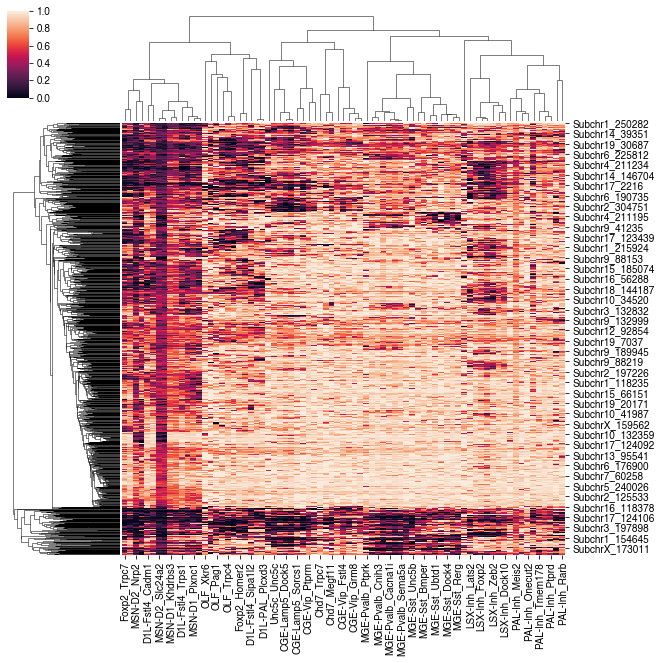

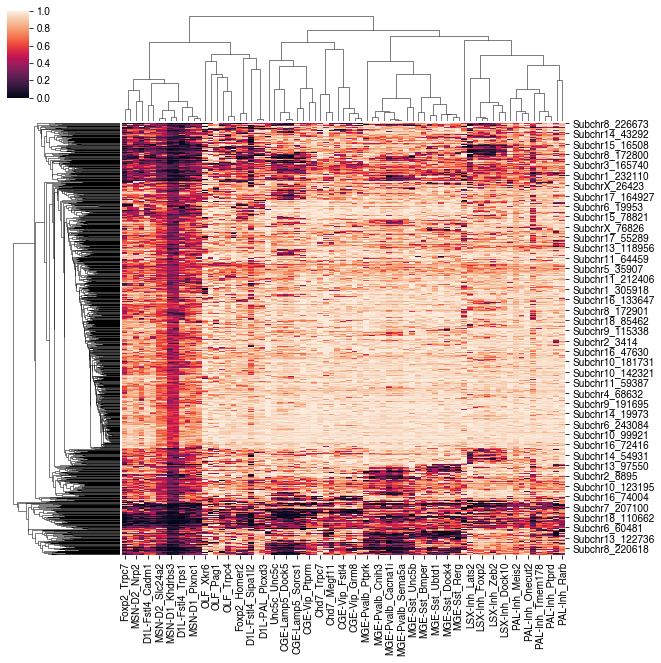

In [21]:
node = '106'

node_related_dmr = adata.var_names[adata.var_vector(node) > 0.3]

left_nodes = [i.replace(' ', '_') for i in node_cluster_dict[int(node)]['left']]
right_nodes = [i.replace(' ', '_') for i in node_cluster_dict[int(node)]['right']]

sns.clustermap(dmr_rate.loc[node_related_dmr, cluster_linkage_order].sample(1000).fillna(0.8), 
               col_linkage=cluster_linkage)

node_related_dmr = adata.var_names[adata.var_vector(node) < -0.3]

left_nodes = [i.replace(' ', '_') for i in node_cluster_dict[int(node)]['left']]
right_nodes = [i.replace(' ', '_') for i in node_cluster_dict[int(node)]['right']]

sns.clustermap(dmr_rate.loc[node_related_dmr, cluster_linkage_order].sample(1000).fillna(0.8), 
               col_linkage=cluster_linkage)

In [18]:
rs = adata.var_vector(node)

In [19]:
pd.Series(rs[rs!=0]).describe()

count    37551.000000
mean        -0.659663
std          0.751572
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max          1.000000
dtype: float64